In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
import matplotlib.pyplot as plt

## Данные

In [2]:
df = pd.read_csv("/kaggle/input/data-ab-tests/data.gzip", compression='gzip')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') + timedelta(hours=3)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,2023-04-01 09:29:33,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,2023-04-01 10:04:12,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,2023-04-01 22:40:39,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,2023-04-01 11:26:20,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,2023-04-01 10:33:09,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01


In [3]:
def get_groups(df):
    
    groups = {
        'pre_group': df[df['group'].isna()].drop('group', axis=1),
        'alpha_group': df[df['group'] == 'A'].drop('group', axis=1),
        'beta_group': df[df['group'] == 'B'].drop('group', axis=1)
    }
    
    return groups

In [4]:
pre_group = get_groups(df)['pre_group']
print(pre_group.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25759 entries, 0 to 25758
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    25759 non-null  datetime64[ns]
 1   id_user      25759 non-null  object        
 2   sum_payment  25759 non-null  int64         
 3   city         25759 non-null  object        
 4   id_product   25758 non-null  float64       
 5   is_pay       25759 non-null  int64         
 6   date         25759 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 1.6+ MB
None


In [5]:
alpha_group = get_groups(df)['alpha_group']
print(alpha_group.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15389 entries, 25759 to 56402
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    15389 non-null  datetime64[ns]
 1   id_user      15389 non-null  object        
 2   sum_payment  15389 non-null  int64         
 3   city         15389 non-null  object        
 4   id_product   15387 non-null  float64       
 5   is_pay       15389 non-null  int64         
 6   date         15389 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 961.8+ KB
None


In [6]:
beta_group = get_groups(df)['beta_group']
print(beta_group.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15257 entries, 25760 to 56404
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    15257 non-null  datetime64[ns]
 1   id_user      15257 non-null  object        
 2   sum_payment  15257 non-null  int64         
 3   city         15257 non-null  object        
 4   id_product   15257 non-null  float64       
 5   is_pay       15257 non-null  int64         
 6   date         15257 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 953.6+ KB
None


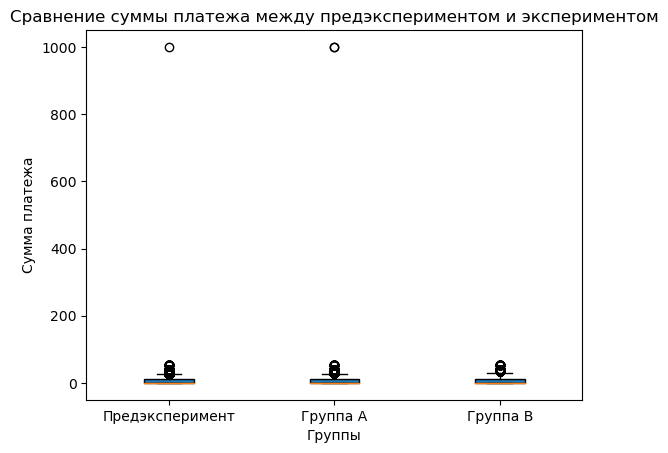

In [7]:
fig, ax = plt.subplots()

ax.boxplot([pre_group['sum_payment'], 
            alpha_group['sum_payment'], 
            beta_group['sum_payment']], 
           patch_artist=True, 
           labels=['Предэксперимент', 'Группа А', 'Группа B'])
ax.set_ylabel('Сумма платежа')
ax.set_xlabel('Группы')
ax.set_title('Сравнение суммы платежа между предэкспериментом и экспериментом')

plt.show()

## Выбросы

In [8]:
def remove_outliers(data, threshold=0.001):
    lower_bound = data["sum_payment"].quantile(q=threshold)
    upper_bound = data["sum_payment"].quantile(q=1 - threshold)
    
    data.loc[data["sum_payment"] < lower_bound, "sum_payment"] = lower_bound
    data.loc[data["sum_payment"] > upper_bound, "sum_payment"] = upper_bound
    
    return data

pre_group = remove_outliers(pre_group)
alpha_group = remove_outliers(alpha_group)
beta_group = remove_outliers(beta_group)

### Даты

In [9]:
PRE_EXP_END = df.date[df.group.isna()].iloc[-1]
EXP_START = PRE_EXP_END + pd.DateOffset(days=1)
EXP_END = PRE_EXP_END + pd.DateOffset(days=31)

print(PRE_EXP_END, EXP_START, EXP_END)

2023-04-30 00:00:00 2023-05-01 00:00:00 2023-05-31 00:00:00


In [10]:
first_user_day = pre_group.groupby('id_user')['date'].min()
WEEK = pd.DateOffset(weeks=1)

In [11]:
merged = pd.merge(pre_group, first_user_day + WEEK, on="id_user", suffixes=('_start', '_end'))
filtered = merged[merged['date_start'] <= merged['date_end']]

filtered.head()

,timestamp,id_user,sum_payment,city,id_product,is_pay,date_start,date_end
0,2023-04-01 09:29:33,user_9903,27,Санкт-Петербург,4.0,1,2023-04-01,2023-04-08
1,2023-04-02 13:42:32,user_9903,0,Санкт-Петербург,1.0,0,2023-04-02,2023-04-08
2,2023-04-04 04:37:29,user_9903,0,Санкт-Петербург,15.0,0,2023-04-04,2023-04-08
4,2023-04-01 10:04:12,user_6732,0,Рязань,1.0,0,2023-04-01,2023-04-08
5,2023-04-04 16:50:32,user_6732,20,Рязань,5.0,1,2023-04-04,2023-04-08


In [19]:
def metric(data, end):
    filtered = data.groupby('id_user').agg(
        min_timestamp=('timestamp', 'min'), 
        max_timestamp=('timestamp', lambda x: x.min() + WEEK)
    )
    
    merged = data.merge(filtered, on='id_user')
    merged = merged.loc[(merged['timestamp'] <= merged['max_timestamp']) & (merged['timestamp'] >= merged['min_timestamp'])]
    merged = merged.loc[pd.to_datetime(merged['max_timestamp']).dt.normalize() < end]
    
    return merged.groupby('id_user')['sum_payment'].sum().tolist()

In [20]:
def calculate_sample_size(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(1 - beta)
    n = (k + 1) * (z_alpha + z_beta)**2 * (sigma_1**2 + sigma_2**2/k) / delta_effect**2
    return n

In [21]:
metric_values = metric(pre_group, EXP_START)
std = np.std(metric_values)
mean_base = np.mean(metric_values)
effect = 0.1 * mean_base

k = len(np.unique(alpha_group['id_user'].values)) / len(np.unique(beta_group['id_user'].values))

sample_size = int(calculate_sample_size(k, effect, std, std))
sample_size

7202

In [22]:
def calculate_average(data, column):
    return data.groupby("date")[column].nunique().mean()

average_active_users_per_day = calculate_average(pre_group, 'id_user')
average_buying_probability_per_day = calculate_average(pre_group[pre_group['is_pay'] == 1], 'id_user') / average_active_users_per_day

estimated_duration = sample_size / (average_active_users_per_day * average_buying_probability_per_day)
estimated_duration_rounded = round(estimated_duration, 2)

print(f"Оценка длительности: {estimated_duration_rounded}")

Оценка длительности: 34.14


In [23]:
def test():
    exp_data = df[~df.index.isin(pre_group.index)]
    first_appearance_date_experiment = exp_data.groupby('id_user').date.min()
    
    merged_exp = pd.merge(exp_data, first_appearance_date_experiment + WEEK, on="id_user")
    
    filtered_exp = merged_exp[merged_exp['date_x'] <= merged_exp['date_y']]
    mean_A = filtered_exp[filtered_exp['group'] == "A"].groupby("id_user")['sum_payment'].sum().mean()
    mean_B = filtered_exp[filtered_exp['group'] == "B"].groupby("id_user")['sum_payment'].sum().mean()
    
    effect = (mean_B - mean_A) / mean_A
    A_payments = filtered_exp[filtered_exp['group'] == "A"].groupby("id_user")['sum_payment'].sum()
    B_payments = filtered_exp[filtered_exp['group'] == "B"].groupby("id_user")['sum_payment'].sum()
    
    return effect, stats.ttest_ind(A_payments, B_payments)

In [24]:
test()

(0.06661564042334184,
 Ttest_indResult(statistic=-2.0247290568973346, pvalue=0.04291729803391671))

In [ ]:
def metric(data, end):
    filtered = data.groupby('id_user').agg(
        min_timestamp=('timestamp', 'min'), 
        max_timestamp=('timestamp', lambda x: x.min() + WEEK)
    )
    
    merged = data.merge(filtered, on='id_user')
    merged = merged.loc[(merged['timestamp'] <= merged['max_timestamp']) & (merged['timestamp'] >= merged['min_timestamp'])]
    merged = merged.loc[pd.to_datetime(merged['max_timestamp']).dt.normalize() < end]
    
    return merged.groupby('id_user')['sum_payment'].sum().tolist()

In [ ]:
p_values = []
metrics = []

exp_data = df[~df.index.isin(pre_group.index)]

first_appearance_date_experiment = exp_data.groupby('id_user').date.min()
# first_appearance_date_experiment = pd.to_datetime(first_appearance_date_experiment).apply(lambda x: x + WEEK)
first_appearance_date_experiment = first_appearance_date_experiment + WEEK

merged_experiment_data = pd.merge(exp_data, first_appearance_date_experiment, on="id_user")

for day in pd.date_range(EXP_START, EXP_END):
    cur_data = merged_experiment_data[merged_experiment_data.date_x <= day]
    cur_data = cur_data[cur_data.date_x <= cur_data.date_y]
    
    cur_A_payments = cur_data[cur_data.group == "A"].groupby("id_user").sum_payment.sum()
    cur_B_payments = cur_data[cur_data.group == "B"].groupby("id_user").sum_payment.sum()
#         print(len(cur_A_payments), len(cur_B_payments))

    cur_mean_payment_A = cur_A_payments.mean()
    cur_mean_payment_B = cur_B_payments.mean()
#         print(cur_mean_payment_A, cur_mean_payment_B)

    cur_effect = cur_mean_payment_B - cur_mean_payment_A
    metrics.append(cur_effect)

    t_test, p_value = stats.ttest_ind(cur_A_payments, cur_B_payments)
    p_values.append(p_value)

In [82]:
metrics, p_values = analyze_experiment(df, EXP_START, EXP_END)

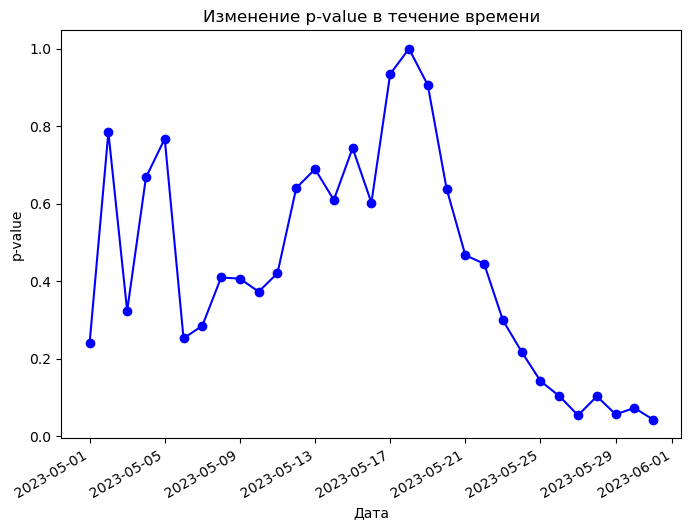

In [83]:
fig, ax = plt.subplots()
ax.plot(pd.date_range(EXP_START, EXP_END), p_values, marker='o', linestyle='-', color='blue')

ax.set_xlabel('Дата')
ax.set_ylabel('p-value')
ax.set_title('Изменение p-value в течение времени')

fig.autofmt_xdate()
fig.set_size_inches(8, 6)
plt.show()

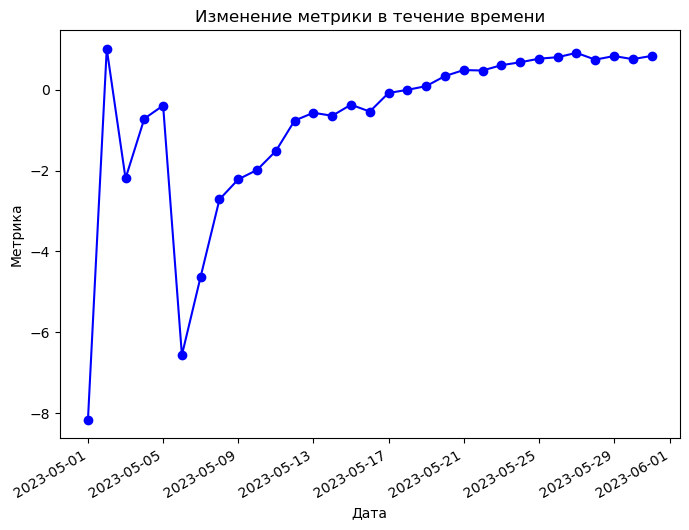

In [84]:
fig, ax = plt.subplots()
ax.plot(pd.date_range(EXP_START, EXP_END), metrics, marker='o', linestyle='-', color='blue')

ax.set_xlabel('Дата')
ax.set_ylabel('Метрика')
ax.set_title('Изменение метрики в течение времени')

fig.autofmt_xdate()
fig.set_size_inches(8, 6)
plt.show()